In [1]:
from elasticsearch import Elasticsearch, RequestError, TransportError
import json
import multiprocessing
import numpy as np
import os
import pandas as pd
import time
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# Set current working directory
os.chdir("../cord_19_dataset")
os.getcwd()

'/home/nrs/SideProjects/COVID19_Research_Analysis/cord_19_dataset'

**Regular-Ass Pandas Dataframes**

In [ ]:
metadata_filename = "metadata.csv"
metadata_cols = list(pd.read_csv(metadata_filename, nrows=0).columns)
metadata_cols_dtypes = {col: str for col in metadata_cols}
metadata_df = pd.read_csv(metadata_filename, dtype=metadata_cols_dtypes)

In [ ]:
metadata_df = metadata_df.dropna(subset=["title"], how="all")
metadata_df = metadata_df.fillna("")
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
doc_embeddings = tfidf_vectorizer.fit_transform(metadata_df["title"])
print(f"Embeddings type: {type(doc_embeddings)}")
print(f"pd.Series embedding shape: {doc_embeddings.shape}")

**Dask Dataframes**<br>
How to use Dask to deal with dataframes that don't fit in memory? We'll find out here.

Dask is a parallel computing library (one machine or distributed) that offers abstractions to **work with numpy and pandas datasets larger than a single machine's memory through parallel computation**. Numpy, pandas, and sklearn were not designed to scale beyond a single CPU or its machine's memory. Dask solves this problem by becoming a platform to build distributed data applications. <br>

Dask parallelizes computation via partitions. Dask dataframes are made up of many panda dataframes (i.e. partition), loaded lazily and in parallel. A single method call or computation on a Dask dataframe makes the corresponding pandas method call on each partition, all done in parallel across partitions. This also allows the programmer to interact with Dask dataframes larger than memory, **so long as each partition fits into memory**. Furthermore, Dask dataframes are *lazily loaded*, meaning that operations on a Dask dataframe builds up a task (computation) graph. Only when compute is called upon the Dask dataframe does the parallel computation execute. <br>

Thus, Dask's power comes from running intensive computations on large out-of-memory datasets in parallel with a small memory footprint.

Breaking Dask down simply, we have two components: <br>
1. **High-Level Collections:** Dask provides high-level data structures that mimic Numpy and Pandas, but can operate on datasets that don't fit into main memory in parallel. Basically, they're alternative to Numpy and Pandas for large datasets.  
2. **Low-Level Schedulers:** Dask provides dynamic task schedulers that execute task DAGs in parallel. These execution engines power computations on the above high-level collections. They allow for fast computations on out-of-memory datasets with a minimal memory footprint. Basically, they're alternatives to multiprocessing and multithreading and other task scheduling systems like Luigi.   

In [3]:
import dask.dataframe as dd
from dask.distributed import Client

num_cpu_cores = multiprocessing.cpu_count()
client = Client(n_workers=num_cpu_cores)  # Set to number of cores of machine
client.cluster

In [ ]:
from time import sleep

def inc(x):
    # sleep(1)
    return x + 1

def add(x, y):
    # sleep(1)
    return x + y

In [ ]:
%%time
from dask import delayed

# This runs immediately, all it does is build a graph
# delayed(computation_func_name)(param_0, param_1, ...) where params can also be dask.Delayed objects

x = delayed(inc)(1)  # Computation graph with one node
y = delayed(inc)(2)  # Computation graph with one node
z = delayed(add)(x, y)  # Computation graph with three nodes

In [ ]:
%%time

x.visualize()
# z = lazy dask.Delayed object (computation graph)
# z.compute() passes computation graph into an execution engine 
# (which parallelizes workload with minimal memory footprint), 
# yielding actual result of computation
z.compute() 
z.visualize()  # Visualize computation graph

**Parallelizing Computations using Dask**

In [ ]:
%%time

data = [1, 2, 3, 4, 5, 6, 7, 8]
results = []

for x in data:
    y = delayed(inc)(x)  # Reminder: doesn't actually perform computation here
    results.append(y)  # Add dask.Delayed object to list

# Params = list of dask.Delayed objects, total = dask.Delayed object (contains computation DAG)
# No actual computation performed below; just building the computation DAG!
total = delayed(sum)(results)
print("Before computing:", total)  # Let's see what type of thing total is
result = total.compute()
print("After computing :", result)  # After it's computed
total.visualize()

**Apply Dask to CORD19 Dataset**

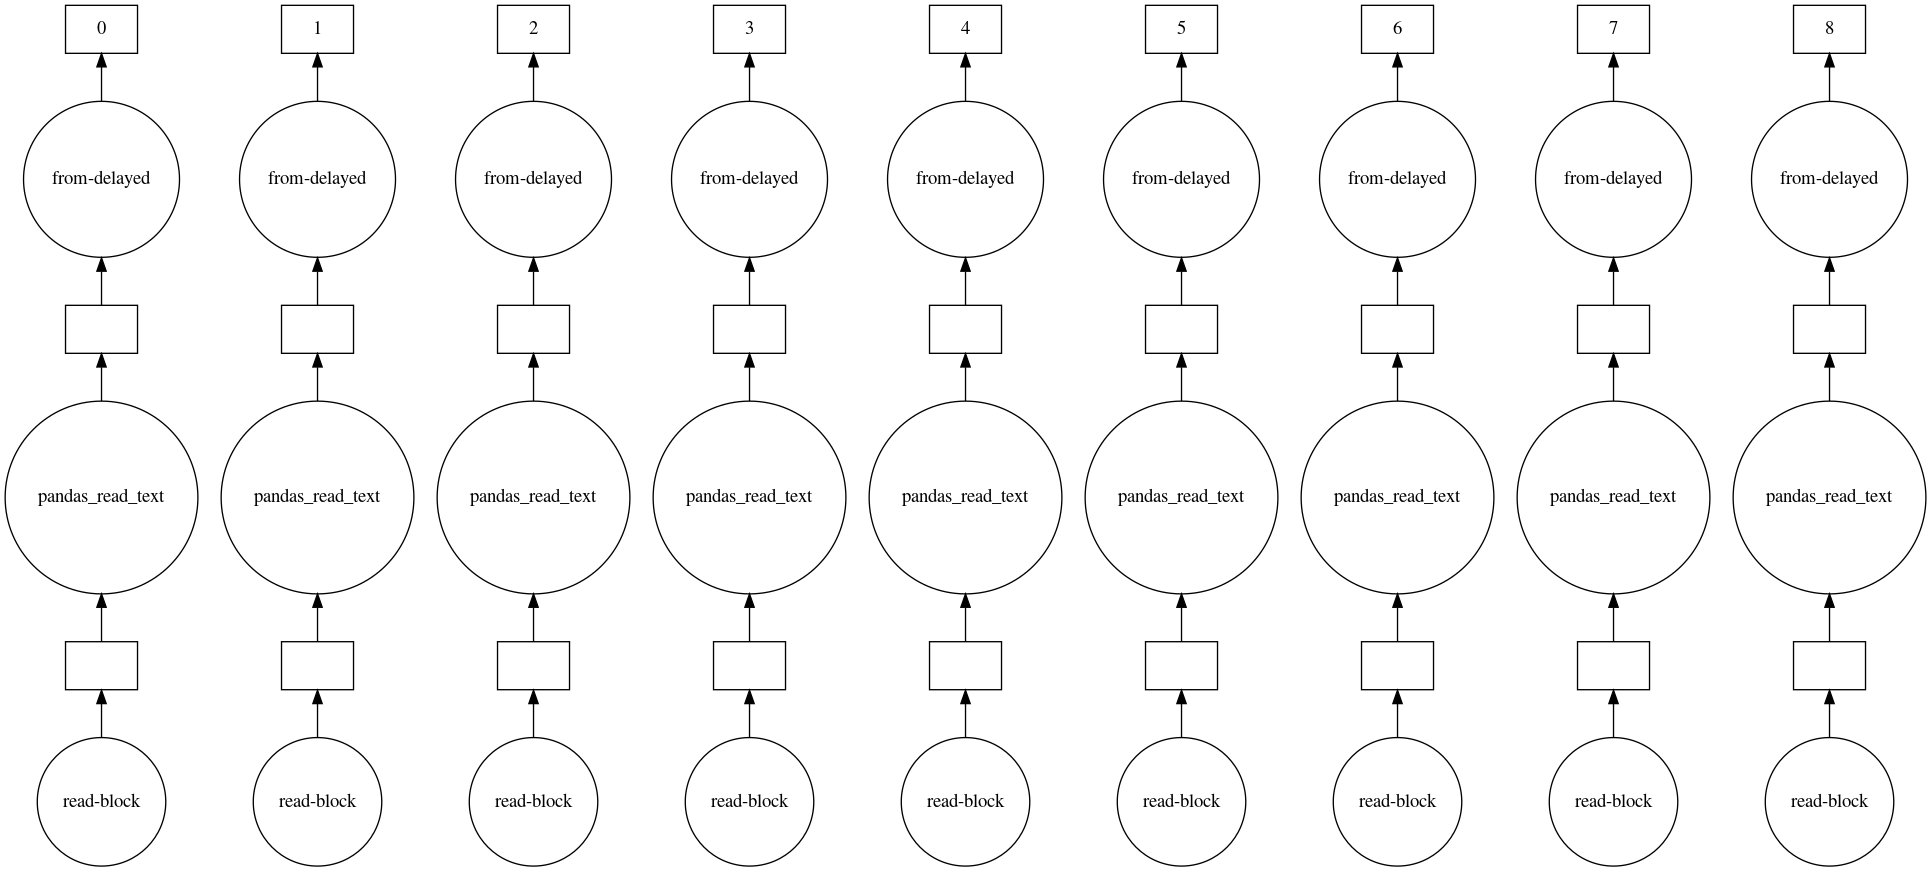

In [28]:
metadata_filename = "metadata.csv"
metadata_cols = [
    "cord_uid", "title", "authors", "abstract", "publish_time", "url", "journal", "pdf_json_files",
]
metadata_cols_dtypes = {col: str for col in metadata_cols}
metadata_dd = dd.read_csv(metadata_filename, dtype=metadata_cols_dtypes, usecols=metadata_cols)
metadata_dd.visualize()

Computations when building the elasticsearch index:<br>
File: `build_research_paper_index.py` <br>
1. `retrieve_paper_body_text` (bunch of file reads and string appending via loops)
2. `remove_papers_with_null_cols` (pandas df mutation)
3. `fill_in_missing_data` (pandas df mutation)
4. `generate_embeddings` (mathematical operations like dot products and sums) <br>
The goal is not to parallelize the computations themselves. What we want to parallelize is its operation on the out-of-memory Dask dataframe. Thus, there will be 4 separate computation graphs, each one having a computation node for each partition of the Dask dataframe. 

In [29]:
%%time

print(f"Num rows before: {metadata_dd.shape[0].compute()}")
metadata_dd = metadata_dd.dropna(subset=["title"], how="all")  # remove_papers_with_null_cols
metadata_dd = metadata_dd.dropna(subset=["abstract", "url"], how="all")  # remove_papers_with_null_cols
print(f"Num rows after: {metadata_dd.shape[0].compute()}")
print(f"Null cols before: {metadata_dd.columns[metadata_dd.isna().any().compute()].tolist()}")
metadata_dd = metadata_dd.fillna("")  # fill_in_missing_data
print(f"Null cols after: {metadata_dd.columns[metadata_dd.isna().any().compute()].tolist()}")

Num rows before: 379974
Num rows after: 328190
Null cols before: ['abstract', 'publish_time', 'authors', 'journal', 'pdf_json_files', 'url']
Null cols after: []
CPU times: user 408 ms, sys: 47.5 ms, total: 456 ms
Wall time: 7.26 s


In [30]:
print(f"Metadata dd shape: {metadata_dd.shape}")  # (Delayed shape, # cols)
print(f"Metadata dd types: {metadata_dd.dtypes}")
print(f"Metadata dd # partitions: {metadata_dd.npartitions}")
print(f"Metadata dd index: {metadata_dd.index}")

Metadata dd shape: (Delayed('int-ce9021b6-8489-48ba-8f67-e66eb8b95dc1'), 8)
Metadata dd types: cord_uid          object
title             object
abstract          object
publish_time      object
authors           object
journal           object
pdf_json_files    object
url               object
dtype: object
Metadata dd # partitions: 9
Metadata dd index: Dask Index Structure:
npartitions=9
    int64
      ...
    ...  
      ...
      ...
dtype: int64
Dask Name: fillna, 63 tasks


In [31]:
%%time

cleaned_metadata_df = metadata_dd.compute(scheduler="processes")
print(f"Metadata dd memory usage: {cleaned_metadata_df.memory_usage(deep=True).sum()}")  # 741MB
print(f"Metadata dd shape: {cleaned_metadata_df.shape}")  # (328190, 8)

Metadata dd memory usage: 741221421
Metadata dd shape: (328190, 8)
CPU times: user 7.12 s, sys: 1.87 s, total: 8.99 s
Wall time: 11.8 s


In [32]:
def retrieve_paper_body_text(pdf_json_files: str) -> str:
    if pdf_json_files and type(pdf_json_files) is str:
        for json_path in pdf_json_files.split("; "):
            paper_body_text = []

            try:
                with open(json_path) as paper_json:
                    full_text_dict = json.load(paper_json)

                    for paragraph_dict in full_text_dict["body_text"]:
                        paragraph_text = paragraph_dict["text"]
                        section_name = paragraph_dict["section"]
                        if section_name.lower() != "abstract":
                            paper_body_text.append(paragraph_text)

                if paper_body_text:  # Stop searching through pdf_json_files
                    return "\n".join(paper_body_text)
            except FileNotFoundError as e:
                print(f"Failed on {json_path} with exception: {str(e)}")

    return ""

def retrieve_paper_body_text_for_series(pdf_json_files_series: pd.Series) -> pd.Series:
    return pdf_json_files_series.apply(lambda pdf_json_files: retrieve_paper_body_text(pdf_json_files))

def generate_embeddings(embedding_type: str, docs: pd.Series) -> pd.Series:
    if embedding_type == "tfidf":
        tfidf_vectorizer = TfidfVectorizer(stop_words='english')
        doc_embeddings = tfidf_vectorizer.fit_transform(docs)
        print(f"Title embeddings shape: {doc_embeddings.toarray()}")
    else:
        try:
            # TODO: Correctly load and generate embeddings using CORD19 embeddings and HuggingFace transformers lib
            embeddings = DEEP_EMBEDDINGS_MAP[embedding_type]
        except KeyError:
            raise KeyError(
                f"Embedding type {embedding_type} nonexistent in embedding map: {DEEP_EMBEDDINGS_MAP}. Make sure the embedding type exists as a key in the embedding map."
            )

    return doc_embeddings

Failed on foo with exception: [Errno 2] No such file or directory: 'foo'
Failed on foo with exception: [Errno 2] No such file or directory: 'foo'


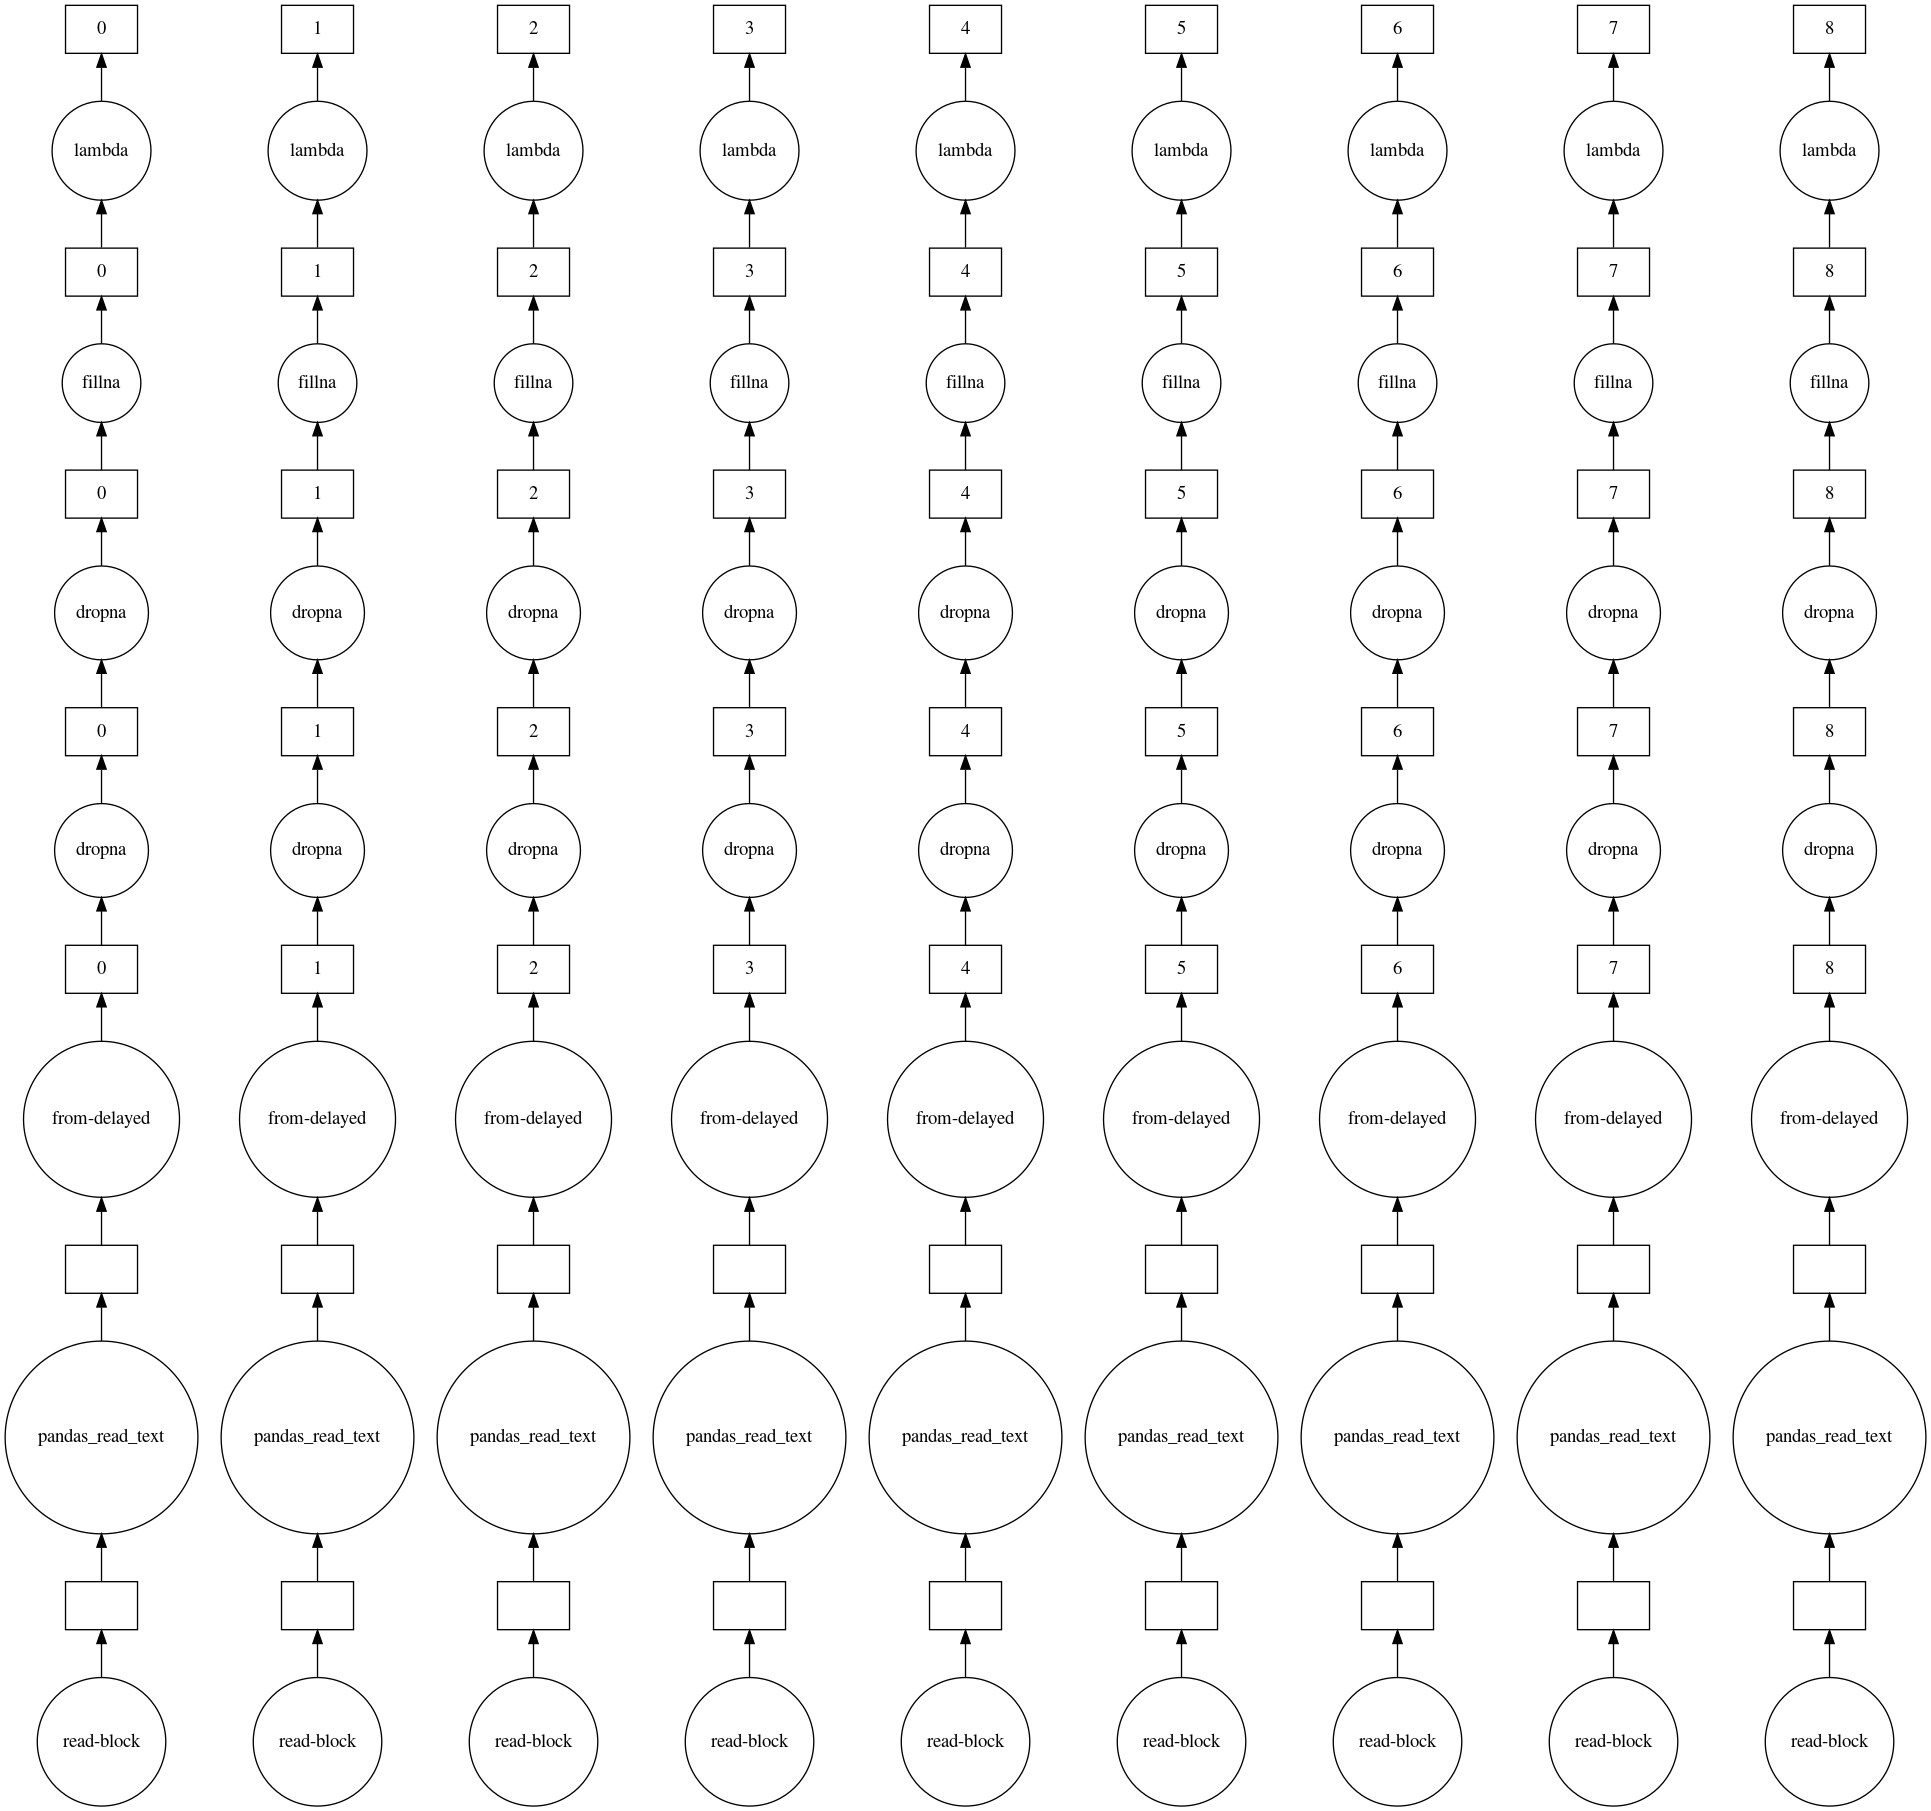

In [33]:
metadata_body_col_dd = metadata_dd.map_partitions(
    lambda df: retrieve_paper_body_text_for_series(df.pdf_json_files)
)
metadata_body_col_dd  # Dask.Series
metadata_body_col_dd.visualize()

In [ ]:
%%time

# Runs into MemoryError
metadata_body_col_series = metadata_body_col_dd.compute(scheduler="processes")
metadata_body_col_series

Failed on foo with exception: [Errno 2] No such file or directory: 'foo'
Failed on foo with exception: [Errno 2] No such file or directory: 'foo'
CPU times: user 29.7 ms, sys: 51.2 ms, total: 80.9 ms
Wall time: 261 ms


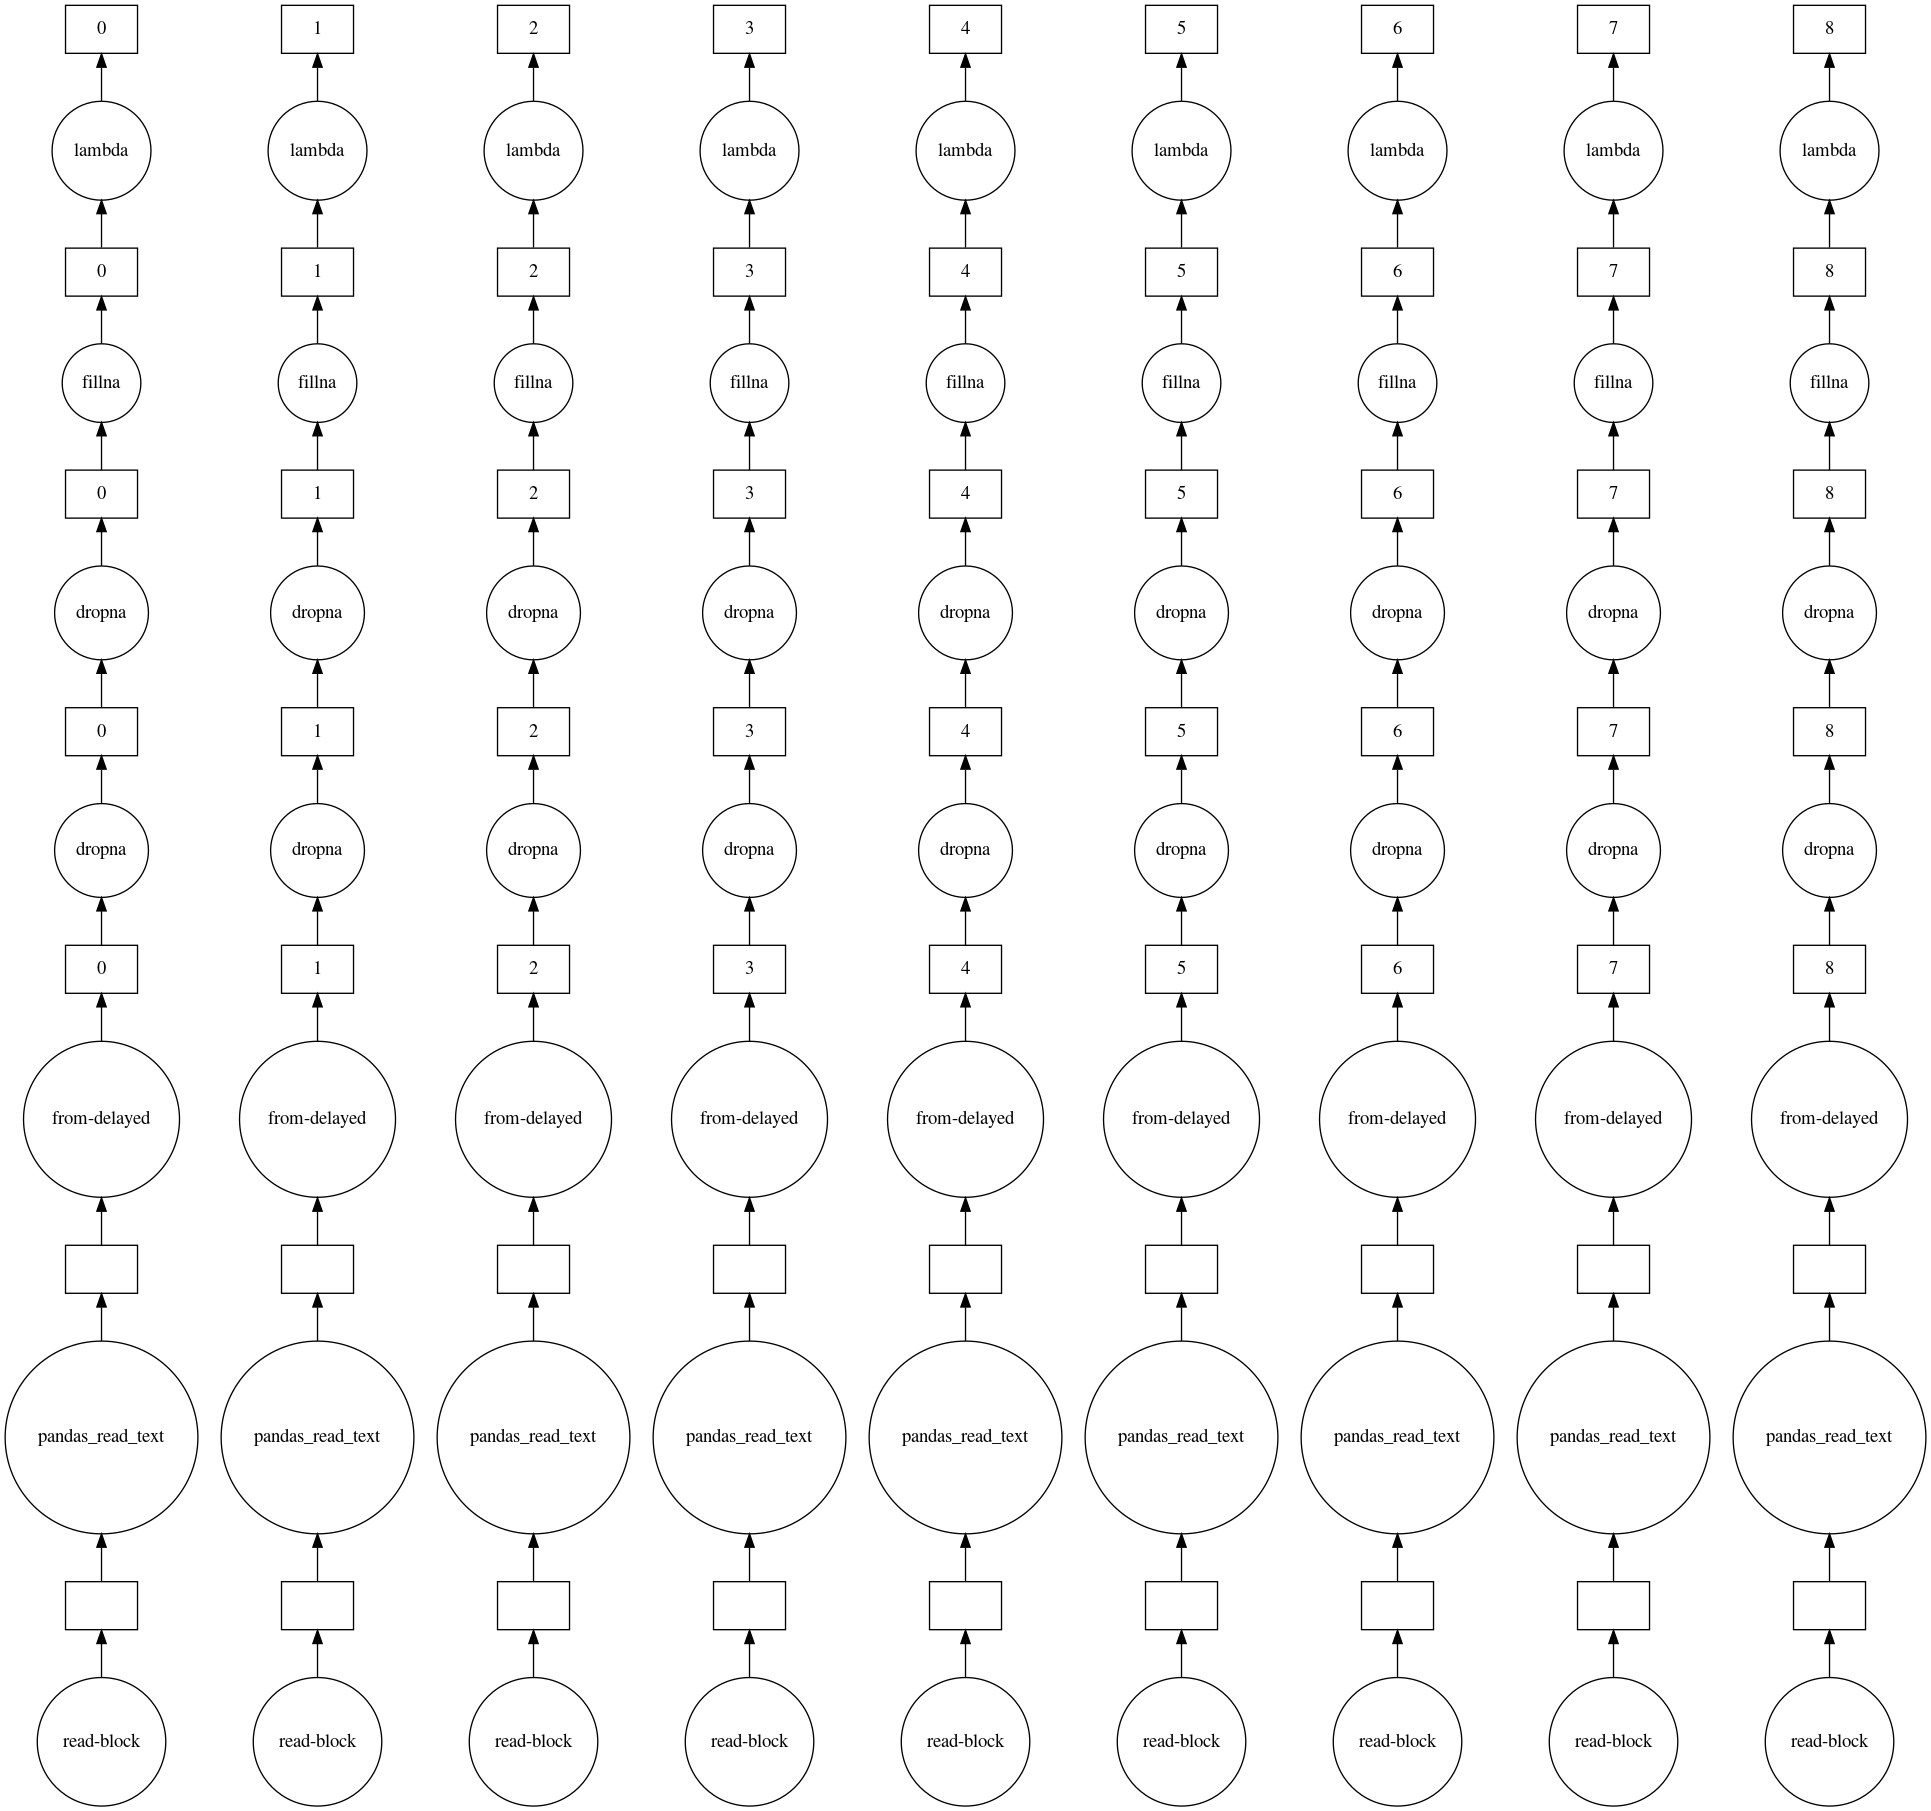

In [22]:
%%time

"""Generate tfidf embeddings for title and abstract"""
"""
metadata_dd = metadata_dd.map_partitions(
    lambda df: df.assign(
        title_tfidf_embedding=generate_embeddings("tfidf", df.title)
    )
)
metadata_dd = metadata_dd.map_partitions(
    lambda df: df.assign(
        abstract_tfidf_embedding=generate_embedding("tfidf", df.abstract)
    )
)
"""
# TODO: Set index 

metadata_dd_with_body = metadata_dd.map_partitions(
    lambda df: df.assign(
        body=retrieve_paper_body_text_for_series(df.pdf_json_files)
    )
)
# metadata_dd_with_body = metadata_dd_with_body.repartition(partition_size="100MB")
metadata_dd_with_body.visualize()

In [ ]:
# Runs into MemoryError
metadata_df_with_body = metadata_dd_with_body.compute(scheduler="processes")

In [ ]:
%%time

def get_partition_size(dd, n):
    return dd.get_partition(n).memory_usage(deep=True).sum().compute()

def get_df_size(df):
    return df.memory_usage(deep=True).sum()
    
total_mem_usage = get_df_size(metadata_dd).compute()
print(f"Total memory usage of metadata_dd: {total_mem_usage}")
mem_usages_by_partition = metadata_dd.map_partitions(get_df_size).compute()
print(f"Memory usage by partition: {mem_usages_by_partition}")

Below cell will run into OOM error since compute() function loads the result (in this case, the entire df) into memory. <br>
Thus, we have to figure out a way to keep it as a lazily loaded dask.Dataframe even after transformation. <br> <br>
**Solution 1:**
Maybe for the new cols (body, tf-idf/bert/cord19 embeddings), we create new dask.Dataframes for those. <br>
These new dask.Dataframes should preserve the order, so then we can just do the same operation of:
```
metadata_dd.iloc[start_idx: start_idx+CHUNK_SIZE].compute(), 
body_dd.iloc[start_idx: start_idx+CHUNK_SIZE],
embeddings_dd.iloc[start_idx: start_idx+CHUNK_SIZE].compute()
```
**Solution 2:**
Above solution is stupid. The metadata_dd up until now, as shown in the computation graph above, has all the computations loaded. <br>
Thus, when we chunk the pandas df by a factor of `CHUNK_SIZE=1000` when sending it to the Elasticsearch index, we can simply call compute() on it that time and all the transformations will occur. It will be loaded into memory, BUT only `CHUNK_SIZE` rows at a time (which should definitely be small enough to not lead to OOM error, but confirm my calling `dd.iloc[start_idx:start_idx+CHUNK_SIZE].compute().memory_usage().sum()`).

In [ ]:
# Note: Don't want to do this, especially since the whole point of Dask is to never load entire dataframes into memory
# metadata_dd.compute(scheduler="processes")

COVID19_PAPERS_INDEX = "covid19_papers"
DATA_TYPE = "research_paper"
UPLOAD_CHUNK_SIZE = 500

def rec_to_actions(df, index, data_type):
    for record in df.to_dict(orient="records"):
        record_id = record["cord_uid"]
        yield (
            '{ "index" : { "_index" : "%s", "_type" : "%s", "_id": "%s" }}'
            % (index, data_type, record_id)
        )
        yield (json.dumps(record))

def upload_papers_to_es_idx(
    papers_df, es_idx, es_hosts, data_type=DATA_TYPE, chunk_size=UPLOAD_CHUNK_SIZE
):
    """
    Uploading Pandas DF to Elasticsearch Index: https://stackoverflow.com/questions/49726229/how-to-export-pandas-data-to-elasticsearch
    """
    # TODO: Catch other exceptions in the future: https://elasticsearch-py.readthedocs.io/en/master/exceptions.html
    try:
        es = Elasticsearch(hosts=es_hosts)
        es.indices.create(index=es_idx, ignore=400)
    except RequestError:
        print(f"Index {es_idx} already exists; continue uploading papers to {es_idx}")

    try:
        """idx = 0
        # num_rows = papers_df.shape[0].compute()
        num_rows = chunk_size
        while idx < num_rows:
            if idx + chunk_size < num_rows:
                max_idx = idx + chunk_size
            else:
                max_idx = num_rows

            start = time.time()
            # TODO: Due to partitioning, index of dask.Dataframe are NOT unique! They reset upon a new partition.
            # To fix this:
            # 1. Repartition to 100MB size
            # 2. Modify http_max_content_length in docker-compose.yml file under env
            # 3. Call compute on each partition (.get_partition(n).compute(scheduler="processes"))
            # Won't be parallel anymore (since parallelization is done across partitions), 
            # but at least Dask helps us in dealing with OOM datasets (solves OOM problem but not parallelization)
            # Thus, it could be argued that we don't even need Dask in this case. We could simply read in the
            # pandas df as chunks (instead of partitions) 
            # Modifying elasticsearch.yml configs: 
            # https://discuss.elastic.co/t/elastic-cluster-docker-or-vm-for-production/203567
            # https://stackoverflow.com/questions/44002643/how-to-use-the-official-docker-elasticsearch-container
            # Reminder that we have to go to these lengths b/c Dask indices are dependent on partitions and 
            # doesn't support 
            papers_df_chunk = papers_df.loc[idx:max_idx].compute(scheduler="processes")
            end = time.time()
            print(f"Chunk compute time: {end - start}")
            print(f"Papers chunk memory size: {papers_df_chunk.memory_usage(deep=True).sum()}")
            r = es.bulk(rec_to_actions(papers_df_chunk, es_idx, data_type))
            print(f"Uploaded {papers_df_chunk.shape[0]} papers")
            end_2 = time.time()
            print(f"Chunk upload time: {end_2 - end}")
            idx = max_idx
            print(f"Errors: {r['errors']}")"""
        for partition_num in range(papers_df.npartitions):
            start = time.time()
            papers_dd_partition = papers_df.get_partition(partition_num)
            papers_df_partition = papers_dd_partition.compute()
            compute_end = time.time()
            print(f"Chunk compute time: {compute_end - start}")
            print(f"Papers chunk memory size: {papers_df_partition.memory_usage(deep=True).sum()}")
            print(f"Number of papers in partition: {papers_df_partition.shape[0]}")
            r = es.bulk(rec_to_actions(papers_df_partition))
            upload_end = time.time()
            print(f"Chunk upload time: {upload_end - compute_end}")
            
    except TransportError as te:
        transport_error_413_url = "https://github.com/elastic/elasticsearch/issues/2902"
        transport_error_429_urls = [
            "https://stackoverflow.com/questions/61870751/circuit-breaking-exception-parent-data-too-large-data-for-http-request",
            "https://github.com/elastic/elasticsearch/issues/31197",
        ]
        if te.status_code == 413:
            print(
                f"Transport error with status code 413. Chunk size is too large, so try reducing chunk size constant or increase http.max_content_length in the yml file. More info here: {transport_error_413_url}"
            )
        elif te.status_code == 429:
            print(
                f"Transport error with status code 429. Elasticsearch's JVM heap size is too small, so try increasing ES_HEAP_SIZE env var in docker-compose.yml. More info here: {transport_error_429_urls}"
            )
        print(f"Error stacktrace: {te.error, te.info}")
        return

In [ ]:
%%time

upload_papers_to_es_idx(metadata_dd, COVID19_PAPERS_INDEX, ["localhost"])

**Chunk size: 100** <br>
Chunk compute time: 53.44560766220093 <br>
Papers chunk memory size: 63760 <br>
Uploaded 797 papers <br>
Chunk upload time: 1.0919387340545654 <br>
Errors: False <br>
CPU times: user 2.52 s, sys: 456 ms, total: 2.97 s<br>
Wall time: 54.6 s <br>

**Chunk size: 1000** <br>
Chunk compute time: 50.61113500595093 <br>
Papers chunk memory size: 170575504 <br>
This is when it hits the 413 TransportError b/c in the elasticsearch.yml file of the container, the config var `http.max_content_length = 100MB`, and the papers df chunk memory size = 170.58MB. 

In [ ]:
%%time

# 6.5GB total - 46.5 s
metadata_dd.memory_usage(deep=True).sum().compute(scheduler="processes")

In [ ]:
metadata_dd.partitions

In [ ]:
%%time

metadata_chunk = metadata_dd.loc[0].compute()
metadata_chunk_2 = metadata_dd.loc[0:1000].compute()

In [ ]:
metadata_chunk_2.shape

In [ ]:
metadata_df[metadata_df["cord_uid"] == "soksrmkx"]
metadata_dd.index.value_counts().compute()